# Required library installations

In [ ]:
#!conda install langdetect -y
#!conda install boto3 -y
#!conda activate MLenv
#!conda install --name MLenv pip -y
#!pip install ray
#!pip uninstall ray -y
#!conda install dask -y
#! conda install numpy --name MLenv -y
#! pip3 install numpy --upgrade
#!conda install modin -y
#!conda uninstall --name MLenv modin -y
#!pip install modin
#!pip uninstall modin -y
#!pip install scispacy
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.3.0/en_core_sci_lg-0.3.0.tar.gz
#!pip install dask-ml
# see https://allenai.github.io/scispacy/


In [ ]:
https://towardsdatascience.com/getting-started-with-pyspark-on-amazon-emr-c85154b6b921
https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf    
    
https://aws.amazon.com/blogs/machine-learning/deploying-machine-learning-models-as-serverless-apis/
    
    
https://www.youtube.com/watch?v=SEQbb8w7VTw
    
buy stocks

In [ ]:
#import modin.pandas as pd

In [ ]:
import sys
for p in sys.path:
    print(p)

# Import Libraries

In [1]:
from tqdm.notebook import trange, tqdm
from time import sleep

import numpy as np 
import pandas as pd 
#import dask.dataframe as dd
import glob
import json



# (1) DATA EXPLORATION

### Select a subset of JSON files in order to start testing your code 
### Approach:

* 10 json files
* 50 json files
* 1000 json files
* 5000 json files
* 10000 json files
* 50000 json files 

In [2]:
%%time

# LOADS PATH OF JSON OBJECTS
root_path = 'archive/document_parses/pdf_json'
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)

print('''
{} JSON documents 
'''.format(len(all_json)))

subset_json = all_json[:10000]


118839 JSON documents 

CPU times: user 241 ms, sys: 262 ms, total: 502 ms
Wall time: 1.07 s


## ❌Option 1: Parse JSON to PD DataFrame 

This was my first approach, but parsing 50,000 records took approximately 30 minutes.
I went ahead and explored using distributed, parallel processing by using Ray Libary (Option 2) 

In [ ]:
%%time

# Create columns and DataFrame
# Approach is to create a dataframe with the size of the number of json files
# one row per json file 

def json2DF(json_lst):
    
    
   
    length = len(json_lst)
    cols = ['paper_id', 'title','body_text','abstract','authors', 'url', 'doi']
    int_covidDF = pd.DataFrame(columns=cols, index=range(length))
    #int_covidDF = dd.from_pandas(tempDF, npartitions=3)

    # Iterate through all json objects 
    for index, path in enumerate(tqdm(json_lst, desc='JSON Files being processed')):
        #print(index)
        #load json object
        try:
            with open(path) as f:
                d = json.load(f)
        except:
            continue

        # Get the paper ID 
        int_covidDF.loc[index]['paper_id'] = d['paper_id']

        # Some json files do not have title so the data has to be pulled from metadata dataframe    
        meta_data = meta_dataDF.loc[meta_dataDF['sha'] == d['paper_id']]

        try:
            #print(d['metadata']['title'][:5])
            if len(d['metadata']['title']) > 0:
                int_covidDF.loc[index]['title'] = d['metadata']['title']
                #print('got it from json')
            elif len(meta_data['title'])>0:
                int_covidDF.loc[index]['title'] = meta_data['title']
                #print('got it from meta')
        except:
            int_covidDF.loc[index]['title'] = None


        #body of text 
        int_covidDF.loc[index]['body_text'] = ''.join(pd.json_normalize(d, record_path=['body_text']).text)


        # abstract
        try:
            if len(pd.json_normalize(d, record_path=['abstract'])) > 0:          
                int_covidDF.loc[index]['abstract'] = ''.join(pd.json_normalize(d, record_path=['abstract'])['text'])
            elif len(meta_data['abstract'].values[0]) > 0:
                int_covidDF.loc[index]['abstract'] = ''.join(meta_data['abstract'].values)
                #print("here", index)
        except:        
            int_covidDF.loc[index]['abstract'] = 'No abstract was found'


        # Authors first and last name
        try:
            if len(pd.json_normalize(d, record_path=['metadata','authors'])['first'].values + ' ' + pd.json_normalize(d, record_path=['metadata','authors'])['last'].values) > 0:
                int_covidDF.loc[index]['authors'] = pd.json_normalize(d, record_path=['metadata','authors'])['first'].values + ' ' + pd.json_normalize(d, record_path=['metadata','authors'])['last'].values

            elif len(meta_data['authors'] > 0):
                int_covidDF.loc[index]['authors'] = meta_data['authors']

        except:

            int_covidDF.loc[index]['authors'] = ''


        if len(meta_data['url'].values) > 0:
            int_covidDF.loc[index]['url'] = meta_data['url'].values
        else:
            int_covidDF.loc[index]['url'] = np.nan

        if len(meta_data['doi'].values) > 0:
            int_covidDF.loc[index]['doi'] = meta_data['doi'].values
        else:
            int_covidDF.loc[index]['doi'] = np.nan
            
    return int_covidDF

        # Used to display the progress
        # There are around 118,839 json documents divide by the times you want to print
        #if index % (len(all_json) // 5 ) == 0:
        #    print('{} out of {} processed'.format(index, len(all_json)))
    

covidDF = json2DF(subset_json)    
    
covidDF.info()
  

## ✅ Option 2: Parse JSON to a List of Dictionaries

In this approached I parsed the JSON file into a list of dictionaries and distributed the load into the number of cores my computer could handle.  This was done using Ray library, which can be used with a local computer but can also be used with a distributed processing system such as Hadoop EMR. 

This reduced the processing time from ~25 minutes to ~3 minutes

## JSON2DICT function defined

In [3]:
%%time

import os
import ray


# Define the functions
# Decorate the function so that we can trigger it remotely
@ray.remote
def json2Dict(json_lst, df):
    
    #print('THIS IS THE VERSION ', pd.__version__, os.path)
    
    meta_dataDF = df
    #meta_dataDF = pd.read_csv('archive/metadata.csv')
    tempDict = {'paper_id':[], 'title':[],'body_text':[],'abstract':[],'authors':[], 'url':[], 'doi':[]}
   
    length = len(json_lst)
    
    #cols = ['paper_id', 'title','body_text','abstract','authors', 'url', 'doi']
    #int_covidDF = pd.DataFrame(columns=cols, index=range(length))
    

    # Iterate through all json objects 
    for index, path in tqdm(enumerate(json_lst)):
        #print(index)
        #load json object
        try:
            with open(path) as f:
                data = json.load(f)
        except:
            print(index, 'file not processed')
            continue

        # Get the paper ID 
        tempDict['paper_id'].append(data['paper_id'])

        # Some json files do not have title so the data has to be pulled from metadata dataframe    
        meta_data = meta_dataDF.loc[meta_dataDF['sha'] == data['paper_id']]

        try:
            #print(d['metadata']['title'][:5])
            if len(data['metadata']['title']) > 0:
                tempDict['title'].append(data['metadata']['title'])
                #print('got it from json')
            elif len(meta_data['title'])>0:
                tempDict['title'].append(meta_data['title'])
                #print('got it from meta')
        except:
            tempDict['title'].append(None)


        # Body of text 
        tempDict['body_text'].append(''.join(pd.json_normalize(data, record_path=['body_text']).text))


        # abstract
        try:
            if len(pd.json_normalize(data, record_path=['abstract'])) > 0:          
                tempDict['abstract'].append(''.join(pd.json_normalize(data, record_path=['abstract'])['text']))
            elif len(meta_data['abstract'].values[0]) > 0:
                tempDict['abstract'].append(''.join(meta_data['abstract'].values))
                #print("here", index)
        except:        
            tempDict['abstract'].append('No abstract was found')


        # Authors first and last name
        try:
            if len(pd.json_normalize(data, record_path=['metadata','authors'])['first'].values + ' ' + pd.json_normalize(data, record_path=['metadata','authors'])['last'].values) > 0:
                tempDict['authors'].append(pd.json_normalize(data, record_path=['metadata','authors'])['first'].values + ' ' + pd.json_normalize(data, record_path=['metadata','authors'])['last'].values)

            elif len(meta_data['authors'] > 0):
                tempDict['authors'].append(meta_data['authors'])

        except:

            tempDict['authors'].append('')


        if len(meta_data['url'].values) > 0:
            tempDict['url'].append(meta_data['url'].values)
        else:
            tempDict['url'].append(np.nan)

        if len(meta_data['doi'].values) > 0:
            tempDict['doi'].append(meta_data['doi'].values)
        else:
            tempDict['doi'].append(np.nan)
            
    return tempDict



CPU times: user 278 ms, sys: 103 ms, total: 381 ms
Wall time: 969 ms


## Ray: Parallel and distributed computing
### JSON2DICT function executed in a parallel distributed manner

Approach: 

* Get the number of records to be processed
* Get the number of cores in the machine (could be number of nodes in a cluster)
* Divide number of records by the cores, to get how many records will be processed per core
* Loop through all the records to be processed by increments of the number of records processed per core


In [4]:
%%time
import multiprocessing


# Initialize the ray parallel processing
ray.init()

# This puts the dataframe in the distributed ray process 
dist_meta_dataDF = ray.put(pd.read_csv('archive/metadata.csv'))


# Number of cores in machine (12)
cores = multiprocessing.cpu_count()


# Number of records to be processed
length = len(subset_json)

# Records that will be processed by core
# divide by the length 
sizeByCore = int(length/cores)

# Initialize the list that will capture the processed JSON results
lst = []

# Use this to set the index of the JSON records to be processed 
# The following for function will loop through all the records 
# it will be incremented by the number of records by core 
# Since it is a parallel process, it will use all cores of the machines to process the records distributed 
# "evenly"
start = 0
for i in tqdm(range(sizeByCore, length, sizeByCore), desc="Sending parallel processes"):    
    if length-(start+sizeByCore) > sizeByCore:
#         print('''
#         if {}-({}+{}) > {}
#         '''.format(length,start,sizeByCore,sizeByCore))
#         print('Processing {}-{} records'.format(start+1, start+sizeByCore))
        x_id = json2Dict.remote(subset_json[start:start+sizeByCore], dist_meta_dataDF)
    else:
#         print('Processing Last {}-{} records'.format(start, length))
        x_id = json2Dict.remote(subset_json[start:length], dist_meta_dataDF)        
    lst.append(x_id)
    start+=sizeByCore
    
# Process the remaining files 
#lst.append(json2Dict.remote(subset_json[start:], dist_meta_dataDF))

# Block until the tasks are done and get the results.
# x = ray.get(lst)
new_lst = []
for i in tqdm(lst, desc="Processing distributed load"):
    new_lst.append(ray.get(i))

# Shutdown ray     
ray.shutdown()

2020-11-16 00:55:45,155	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
<string>:2: DtypeWarning: Columns (4,5,6,13,14,16) have mixed types.Specify dtype option on import or set low_memory=False.


(pid=8525) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8521) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8519) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8514) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8515) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8522) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8517) HBox(children=(HTML(value=''), FloatProgress(value=1.0, bar_style='info', layout=Layout(width='20px'), max=1.0), HTML(value='')))
(pid=8516) HB

## LOAD THE LIST OF DICTIONARIES INTO A DATAFRAME 

In [5]:
for i in new_lst:
    print(len(i['paper_id']))

833
833
833
833
833
833
833
833
833
833
833
837


In [6]:
covidDF = pd.DataFrame.from_dict(new_lst[0], orient='index').transpose()

for i in tqdm(range(1, len(new_lst)), desc='List of dictionaries into DataFrame'):
    covidDF = covidDF.append(pd.DataFrame.from_dict(new_lst[i], orient='index').transpose(), ignore_index=True)

covidDF.info()
covidDF.head()

del new_lst #Remove list from memory once it's loaded in DF 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   10000 non-null  object
 1   title      9876 non-null   object
 2   body_text  10000 non-null  object
 3   abstract   10000 non-null  object
 4   authors    10000 non-null  object
 5   url        8885 non-null   object
 6   doi        8885 non-null   object
dtypes: object(7)
memory usage: 547.0+ KB


# (2) FEATURE ENGINEERING

Will add the following features:

* **abstract_cnt**    - count number of words in abstract feature
* **body_cnt**        - count the number of words in body
* **unique_body_cnt** - count the number of unique words in body

In [7]:
%%time
import re
# Used regex to find words 
# Then count them 
tqdm.pandas(desc="Finding Text")

covidDF['abstract_cnt'] = covidDF['abstract'].progress_apply(lambda text: len(re.findall(r'\w+', text)))
covidDF['body_cnt'] = covidDF['body_text'].progress_apply(lambda text: len(re.findall(r'\w+', text)))
covidDF['unique_body_cnt'] = covidDF['body_text'].progress_apply(lambda text: len(set(re.findall(r'\w+', text))))

/Users/hectorcarrillo/anaconda3/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



CPU times: user 29.5 s, sys: 477 ms, total: 30 s
Wall time: 29.9 s


### Authors and abstract have fields with blank spaces, so we cannot detect null values in empty strings

In [8]:
covidDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paper_id         10000 non-null  object
 1   title            9876 non-null   object
 2   body_text        10000 non-null  object
 3   abstract         10000 non-null  object
 4   authors          10000 non-null  object
 5   url              8885 non-null   object
 6   doi              8885 non-null   object
 7   abstract_cnt     10000 non-null  int64 
 8   body_cnt         10000 non-null  int64 
 9   unique_body_cnt  10000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 781.4+ KB


### Convert empty strings into Null values so that we can count them 

* run info to see null values again
* we can see that the lowest count for non-null values is doi and url
* these are essential reference fields so it is safe to remove all non-null values

In [9]:
covidDF = covidDF.replace(r'^\s*$', np.nan, regex=True)
covidDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paper_id         10000 non-null  object
 1   title            9876 non-null   object
 2   body_text        10000 non-null  object
 3   abstract         10000 non-null  object
 4   authors          9002 non-null   object
 5   url              8885 non-null   object
 6   doi              8885 non-null   object
 7   abstract_cnt     10000 non-null  int64 
 8   body_cnt         10000 non-null  int64 
 9   unique_body_cnt  10000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 781.4+ KB


In [10]:
# Check for unique values 
print('''
===== ABSTRACT =====

{}

===== BODY TEXT =====

{}
'''.format(covidDF['abstract'].describe(include='all'), covidDF['body_text'].describe(include='all')))



===== ABSTRACT =====

count                     10000
unique                     8254
top       No abstract was found
freq                       1698
Name: abstract, dtype: object

===== BODY TEXT =====

count                                                 10000
unique                                                 9981
top       The nuclear receptor heterodimers of liver X r...
freq                                                      7
Name: body_text, dtype: object



## DROP DUPLICATES

We will work with body text, and care about body_text being unique

In [11]:
%%time

covidDF.drop_duplicates(['body_text'], inplace=True)
covidDF['body_text'].describe(include='all')

CPU times: user 706 ms, sys: 80.9 ms, total: 787 ms
Wall time: 788 ms


count                                                  9981
unique                                                 9981
top       Coronavirus Disease-2019 (COVID- 19) is an acu...
freq                                                      1
Name: body_text, dtype: object

In [12]:
covidDF.describe()

,abstract_cnt,body_cnt,unique_body_cnt
count,9981.000000,9981.000000,9981.000000
mean,187.882978,3976.883078,998.939184
std,196.449414,6909.190702,799.380424
min,0.000000,1.000000,1.000000
25%,73.000000,1520.000000,577.000000
50%,174.000000,3006.000000,887.000000
75%,256.000000,4814.000000,1235.000000
max,5538.000000,243113.000000,14850.000000


In [13]:
covidDF.dropna(subset=['url','doi'], inplace=True)
covidDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8876 entries, 0 to 9998
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paper_id         8876 non-null   object
 1   title            8761 non-null   object
 2   body_text        8876 non-null   object
 3   abstract         8876 non-null   object
 4   authors          8034 non-null   object
 5   url              8876 non-null   object
 6   doi              8876 non-null   object
 7   abstract_cnt     8876 non-null   int64 
 8   body_cnt         8876 non-null   int64 
 9   unique_body_cnt  8876 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 762.8+ KB


## DETECT LANGUAGE 

In order to run the model, we will only process records that are in english.

We will need to detect the language, and I will evaluate 2 options:

* langdetect (https://pypi.org/project/langdetect/) 
* AWS comprehend (price)

### ❌ AWS COMPREHEND API

* pricing Language Detection	$0.0001 per unit 
* NLP requests are measured in units of 100 characters, 
* with a 3 unit (300 character) minimum charge per request.

**Free Tier**
* 50K UNITS OF TEXT (5M CHARACTERS)
* We have 118,839 JSON items
* Leaves us at 68,839 x $0.0001 = $6.00 USD (max cost)

In [ ]:
%%time
# see how to set credentials 
# https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html
# Uses my computer's locally stored credentials for AWS in order to make the calls to the api 


import boto3
import json

session = boto3.Session(profile_name='amplify-ecommerce1')
comprehend = session.client('comprehend')



# Iterate through records

for i in tqdm(covidDF.iloc[:10]['body_text']):
    
    response = comprehend.detect_dominant_language(Text = i[:300])
    language = response['Languages'][0]['LanguageCode']
    
    
    print('''
    Language detected: {}
    Full response: {}
    Sample text: {}        
    '''.format(language, response, i[:50] ))



### ✅ LANGDETECT LIBRARY (Preferred)

* Faster and freee


**Normal Execution :** 

CPU times: user 2min 35s, sys: 1.98 s, total: 2min 37s

Wall time: 2min 36s

**vs**

**Parallel/Distributed Execution :**

CPU times: user 2.46 s, sys: 4.52 s, total: 6.97 s

Wall time: 48.3 s

In [14]:
%%time

from langdetect import detect, DetectorFactory

# Define the functions
# Decorate the function so that we can trigger it remotely
@ray.remote(num_returns=2)
def detectLanguage(textBody):
    
    # For consistent results
    DetectorFactory.seed = 0
    
    # To store issues
    issues = {'paper_id':[], 'body_text':[]}

    # Initialize List to store languages
    language = []

    # Initialize an issues dictionary to store the paper_id and the text of the body 
    # This can be used to remove incorrectly formatted text corpus 
    

    # Iterate through records
    for index, text in enumerate(tqdm(textBody)):

        try:
            language.append(detect(text[:300]))
        except:
            try:
                language.append(detect(text[-300:]))
            except:
                language.append('No text found')
                issues['paper_id'].append(index)
                issues['body_text'].append(text)
                print('No text was found at index {}'.format(index))
    
    return language, issues

        
        

CPU times: user 7.01 ms, sys: 3.39 ms, total: 10.4 ms
Wall time: 13.9 ms


## Ray: Parallel and distributed computing
### JSON2DICT function executed in a parallel distributed manner

Approach: 

* Get the number of records to be processed
* Get the number of cores in the machine (could be number of nodes in a cluster)
* Divide number of records by the cores, to get how many records will be processed per core
* Loop through all the records to be processed by increments of the number of records processed per core

In [15]:
len(covidDF['body_text'])

8876

In [16]:
%%time

# initialize ray
ray.init()

# Number of records to be processed
length = len(covidDF['body_text'])

# Records that will be processed by core
# divide by the length 
sizeByCore = int(length/cores)

# Initialize the list that will capture the processed results
lst = []

# Issues List 
issues = []

# Use this to set the index of the JSON records to be processed 
# The following for function will loop through all the records 
# it will be incremented by the number of records by core 
# Since it is a parallel process, it will use all cores of the machines to process the records distributed 
# "evenly"
start = 0
for i in tqdm(range(sizeByCore, length, sizeByCore), desc="Sending parallel processes"):
    if length-(start+sizeByCore) > sizeByCore:
        print('Processing {}-{} records'.format(start, start+sizeByCore))
        x_id, issue = detectLanguage.remote(covidDF['body_text'][start:start+sizeByCore])
    else:
        print('Processing remaining {}-{} records'.format(start, length))
        x_id, issue = detectLanguage.remote(covidDF['body_text'][start:length])
    lst.append(x_id)
    issues.append(issue)
    start+=sizeByCore
    
# Process the remaining files 
# x_id = detectLanguage.remote(covidDF['body_text'][start:length])
# lst.append(x_id)
# print('Processing Remaining {}-{} records'.format(start, length))


# Block until the tasks are done and get the results.
# x = ray.get(lst)
languageLst = []
for i in tqdm(lst, desc="Unpacking distributed load for languages"):
    languageLst.extend(ray.get(i))

issue_lst = []
for i in tqdm(issues, desc="Unpacking distributed load for issues"):
    issue_lst.append(ray.get(i))
    
# Shutdown ray     
ray.shutdown()

2020-11-16 00:59:10,638	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


Processing 0-739 records
Processing 739-1478 records
Processing 1478-2217 records
Processing 2217-2956 records
Processing 2956-3695 records
Processing 3695-4434 records
Processing 4434-5173 records
Processing 5173-5912 records
Processing 5912-6651 records
Processing 6651-7390 records
Processing 7390-8129 records
Processing remaining 8129-8876 records



(pid=8599) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8595) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8594) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8598) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8597) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8605) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8601) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8596) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8602) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=747.0), HTML(value='')))
(pid=8603) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=739.0), HTML(value='')))
(pid=8600) HBox(children=(HTML(value='')

(pid=8602) 

CPU times: user 633 ms, sys: 557 ms, total: 1.19 s
Wall time: 12.8 s


### Analyze any issues

In [17]:
[i for i in issue_lst if len(i['paper_id']) > 0]

[{'paper_id': [29],
  'body_text': [",%68)6)( &= 8,) ?140)1)28-2+ )'311)2(%8-327 3* 8,) 311-77-32 '8 3* @ 9&0-' %;8,) %8-32%0 -3 796:)-00%2') 28)+6%8-32 )28)6 -7 ,397)( ;-8,-2 8,) )4%68 1)28 3* 31)0%2( )'96-8= !,) 1-77-32 3* -7 83 )2%&0) )%60= ;%62-2+ %2( 7,%6)( 7-89%8-32%0 %;%6)2)77 3* % %'-0-8%8-2+ '300%&36%8-32 %003;)( 7,%6)( 7-89%8-32%0 %;%6)2)77 %2( )2,%2')( ()'-7-32 1%/-2+ &= 7)2-36 0)%()67,-4 3* *)()6%0 %+)2'-)7'336 (-2%8) "]},
 {'paper_id': [78], 'body_text': [' . . . . . . 507 ']}]

### Distribution of languages

In [18]:
from collections import Counter 

print('''
Length of items in List of Languages:
{}
'''.format(len(languageLst)))

Counter(languageLst)


Length of items in List of Languages:
8876



Counter({'en': 8611,
         'de': 102,
         'fr': 62,
         'nl': 7,
         'es': 84,
         'it': 3,
         'pt': 3,
         'No text found': 2,
         'cy': 1,
         'ru': 1})

### Add language feature to the dataframe

Filter the dataframe to select only english documents

In [19]:
covidDF['language'] = languageLst

covidDF = covidDF[covidDF['language'] == 'en']
covidDF.info()

# Delete Unused lists
del issue_lst
del languageLst

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8611 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paper_id         8611 non-null   object
 1   title            8504 non-null   object
 2   body_text        8611 non-null   object
 3   abstract         8611 non-null   object
 4   authors          7852 non-null   object
 5   url              8611 non-null   object
 6   doi              8611 non-null   object
 7   abstract_cnt     8611 non-null   int64 
 8   body_cnt         8611 non-null   int64 
 9   unique_body_cnt  8611 non-null   int64 
 10  language         8611 non-null   object
dtypes: int64(3), object(8)
memory usage: 807.3+ KB


# DATA CLEANING

* Remove stop words
* Remove punctuation
* Use Lemmatization

## STOP WORDS


Custom medical stop words were recommended by: 

https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles

In [20]:
import spacy
import en_core_sci_lg
from spacy.lang.en.stop_words import STOP_WORDS
import string


stop_words = list(STOP_WORDS)
medical_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al',
                      'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using',
                      'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']

stop_words.extend(medical_stop_words) # Converge the 2 lists 
stop_words = list(set(stop_words)) # Remove duplicates 

## Define Clean up function

In [21]:
#nlp = en_core_sci_lg.load(disable=['tagger','ner'])
#nlp.max_length = 7000000

@ray.remote
def cleanUp(lst_text):
    
    nlp = en_core_sci_lg.load(disable=['tagger','ner'])
    nlp.max_length = 7000000
    
    results = []
    
    for text in tqdm(lst_text):
        tokens = nlp(text)
        tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
        tokens = [ word for word in tokens if word not in stop_words and word not in string.punctuation ]
        tokens = ' '.join([i for i in tokens])
        results.append(tokens)
        
    return results
    

In [22]:
# def cleanUp(text):
    
#     nlp = en_core_sci_lg.load(disable=['tagger','ner'])
#     nlp.max_length = 7000000
    

#     tokens = nlp(text)
#     tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
#     tokens = [ word for word in tokens if word not in stop_words and word not in string.punctuation ]
#     tokens = ' '.join([i for i in tokens])
        
#     return tokens

## PROCESS WITH RAY SO IT'S FASTER

In [24]:
%%time

# initialize ray
ray.init()

# Number of records to be processed
length = len(covidDF['body_text'])

# Records that will be processed by core
# divide by the length 
sizeByCore = int(length/cores)

# Initialize the list that will capture the processed results
lst = []


# The following for function will loop through all the records 
# it will be incremented by the number of records by core 
# Since it is a parallel process, it will use all cores of the machines to process the records distributed 
# "evenly"
start = 0
for i in tqdm(range(sizeByCore, length, sizeByCore), desc="Sending parallel processes"):
    if length-(start+sizeByCore) > sizeByCore:
        print('Processing {}-{} records'.format(start, start+sizeByCore))
        x_id = cleanUp.remote(covidDF['body_text'][start:start+sizeByCore])
    else:
        print('Processing remaining {}-{} records'.format(start, length))
        x_id = cleanUp.remote(covidDF['body_text'][start:length])
    lst.append(x_id)
    start+=sizeByCore
    
# Block until the tasks are done and get the results.
# x = ray.get(lst)
processedLst = []
for i in tqdm(lst, desc="Unpacking distributed load for cleaned text"):
    processedLst.extend(ray.get(i))


    
# Shutdown ray     
ray.shutdown()

2020-11-16 01:00:28,829	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


Processing 0-717 records
Processing 717-1434 records
Processing 1434-2151 records
Processing 2151-2868 records
Processing 2868-3585 records
Processing 3585-4302 records
Processing 4302-5019 records
Processing 5019-5736 records
Processing 5736-6453 records
Processing 6453-7170 records
Processing 7170-7887 records
Processing remaining 7887-8611 records



(pid=8678) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8673) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8667) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8676) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=724.0), HTML(value='')))
(pid=8672) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8674) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8669) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8675) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8670) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8677) HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=717.0), HTML(value='')))
(pid=8671) HBox(children=(HTML(value='')

In [25]:
covidDF['cleaned_text'] = processedLst
covidDF.info()

del processedLst
del lst

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8611 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paper_id         8611 non-null   object
 1   title            8504 non-null   object
 2   body_text        8611 non-null   object
 3   abstract         8611 non-null   object
 4   authors          7852 non-null   object
 5   url              8611 non-null   object
 6   doi              8611 non-null   object
 7   abstract_cnt     8611 non-null   int64 
 8   body_cnt         8611 non-null   int64 
 9   unique_body_cnt  8611 non-null   int64 
 10  language         8611 non-null   object
 11  cleaned_text     8611 non-null   object
dtypes: int64(3), object(9)
memory usage: 874.6+ KB


### Spot check 

In [26]:
covidDF.iloc[0]['cleaned_text']

'a1111111111 a1111111111 a1111111111 a1111111111 a1111111111 available datum 78 addition significant increase level lactate dehydrogenase α-hydroxybutyrate dehydrogenase detect 28 patient 34 patient available datum 82 25 patient 34 patient available datum 74 respectively patchy lesion lobule detect chest compute tomographic scan 28 patient 82 ground-glass opacity typical feature adult rare pediatric patient 3 rapid radiologic progression late-onset pattern lesion lobule notice lesions lobule exist 24 32 patient lesion 75 patient discharge main symptom disappear day treatment patient discharge median duration hospitalization 10.00 8.00 14.25 day current study limit small sample size lack dynamic detection inflammatory marker datum systemically present clinical epidemiological feature good outcome pediatric patient covid-19 stratified analysis perform mild moderate case finding offer new insight early identification intervention pediatric patient covid-19.why study done?• severe acute re

count     8611.000000
mean      1000.797584
std        808.436791
min         13.000000
25%        586.000000
50%        884.000000
75%       1225.000000
max      14850.000000
Name: unique_body_cnt, dtype: float64

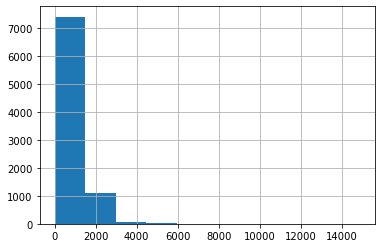

In [27]:
covidDF['unique_body_cnt'].hist()
covidDF['unique_body_cnt'].describe()

# LATENT DIRILECTH ALLOCATION

## USING SCIKIT 

In order to do topic modeling, we need to see what is the optimal number of topics 


## Use k-means to get a number of topics

### Vectorization Function

In [28]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorization(text, _max_features):
    
    vectorizer = TfidfVectorizer(max_features=_max_features)
    result = vectorizer.fit_transform(text)
    return result


text = covidDF['cleaned_text'].values
X = vectorization(text, 2 ** 12)
X.shape

CPU times: user 13.5 s, sys: 385 ms, total: 13.9 s
Wall time: 14.1 s


(8611, 4096)

### PCA principle component analysis 

Reduce dimensions

In [29]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_red= pca.fit_transform(X.toarray())
X_red.shape

CPU times: user 4min 47s, sys: 13 s, total: 5min
Wall time: 54.3 s


(8611, 2285)

### k-means to choose number of topics 

In [30]:
%%time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

start = 2
end = 50

#Iterate through different k values 
distortions = []
for k in tqdm(range(start, end)):
    #k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_red)
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_red)
    k_means.fit(X_red)
    distortions.append(sum(np.min(cdist(X_red, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('found distortions for {} clusters'.format(k))

KeyboardInterrupt: 

## Use dask to speed up processing 



In [38]:
#https://examples.dask.org/machine-learning/incremental.html

from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:51099 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 17.18 GB


In [39]:
import dask
from dask_ml.cluster import KMeans
from scipy.spatial.distance import cdist

start = 2
end = 50

#Iterate through different k values 
distortions = []
for k in tqdm(range(start, end)):
    #k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_red)
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_red)
    k_means.fit(X_red)
    distortions.append(sum(np.min(cdist(X_red, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('found distortions for {} clusters'.format(k))

KeyboardInterrupt: 

In [37]:
client.shutdown()
client.close()


RuntimeError: IOLoop is closed

In [ ]:
import plotly.graph_objects as go
import numpy as np

X_axis = [start, end]
Y_axis = [max(distortions), min(distortions)]

plt1 = go.Scatter(x=[*K], y=distortions)
plt2 = go.Scatter(x=X_axis, y=Y_axis)
data = [plt1, plt2]


fig = go.Figure(data=data)

# Edit the layout
fig.update_layout(title='Elbow method for optimal number of topics',
                   xaxis_title='Number of Topics',
                   yaxis_title='Distortion')

fig.show()

## LATENT DIRILECTH ALLOCATION IMPLEMENTATION

Now that know the number of topics to choose 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
cv = CountVectorizer(max_df = 0.95, stop_words = 'english')

termFrequency = cv.fit_transform(covidDF['cleaned_text'])
featureNames = cv.get_feature_names()

In [ ]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 9, random_state = 42)
lda.fit(termFrequency)

In [ ]:
for index, topic in tqdm(enumerate(lda.components_)):
    print(f'Top 15 words for Topic #{index}')
    print([featureNames[i] for i in topic.argsort()[-15:]])
    print('\n')

In [ ]:
#https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d

#covidDF.iloc[1]['cleaned_text']
nlp = en_core_sci_lg.load(disable=['tagger','ner'])
nlp.max_length = 7000000


sample_txt = '''COVID-19: Psychiatrists warn of coronavirus lockdown's toll on mental health'''

tokens = nlp(covidDF.iloc[0]['cleaned_text'])
tokens = nlp(sample_txt)
tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
tokens = [ word for word in tokens if word not in stop_words and word not in string.punctuation ]
#tokens = ' '.join([i for i in tokens])

tokens

In [ ]:
lda.transform(cv.transform(tokens))

In [ ]:
from statistics import mode

freq_lst = []
for i in lda.transform(cv.transform(tokens)):
    print(i)
    freq_lst.append(i.argmax())
    
cnt = Counter(freq_lst)
cnt

In [ ]:
temp_dict = {'topic_1': [],
             'topic_2':[],
             'topic_3':[], 
             'topic_4':[],
             'topic_5': [],
             'topic_6': [],
             'topic_7': []}



In [ ]:
sum(Counter(freq_lst).values())

print(Counter(freq_lst).keys())
print([i/sum(Counter(freq_lst).values()) for i in Counter(freq_lst).values()])

total = sum(cnt.values())

for i in range(1, len(temp_dict)+1):
    print(i)
    try:
        temp_dict['topic_'+str(i)].append(cnt[i]/total)
    except:
        temp_dict['topic_'+str(i)].append(None)
        
temp_dict

In [ ]:
pd.DataFrame(temp_dict)

In [ ]:
#https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d

#covidDF.iloc[1]['cleaned_text']
nlp = en_core_sci_lg.load(disable=['tagger','ner'])
nlp.max_length = 7000000


sample_txt = '''COVID-19: Psychiatrists warn of coronavirus lockdown's toll on mental health'''

tokens = nlp(covidDF.iloc[0]['cleaned_text'])
tokens = nlp(sample_txt)
tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
tokens = [ word for word in tokens if word not in stop_words and word not in string.punctuation ]
#tokens = ' '.join([i for i in tokens])

tokens

## USING GENSIM 

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb

In [ ]:
import gensim.corpora as corpora
import gensim


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(covidDF['cleaned_text'].str.split(' '))

# Create Corpus
texts = covidDF['cleaned_text'].str.split(' ')

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])


In [ ]:
%%time
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



we can move on to using TF-IDF which is pretty straightforward to do in sklearn

We can maybe use 
LATENT DIRECHT ALLOCATION
https://www.youtube.com/watch?v=3mHy4OSyRf0&t=515s

https://medium.com/analytics-vidhya/topic-modelling-using-latent-dirichlet-allocation-in-scikit-learn-7daf770406c4


Both K-means and Latent Dirichlet Allocation (LDA) are unsupervised learning algorithms, where the user needs to decide a priori the parameter K, respectively the number of clusters and the number of topics.

If both are applied to assign K topics to a set of N documents, the most evident difference is that K-means is going to partition the N documents in K disjoint clusters (i.e. topics in this case). On the other hand, LDA assigns a document to a mixture of topics. Therefore each document is characterized by one or more topics (e.g. Document D belongs for 60% to Topic A, 30% to topic B and 10% to topic E). Hence, LDA can give more realistic results than k-means for topic assignment.

Since our objective is to produce target labels, this is a perfect application for an unsupervised learning algorithm.  We want to segment the documents into different groups so that we can create an api to route to the appropriate cluster. 

We randomly initialize the K starting centroids. Each data point is assigned to its nearest centroid.
The centroids are recomputed as the mean of the data points assigned to the respective cluster.
Repeat steps 1 and 2 until we trigger our stopping criteria.

* Term Frequency-Inverse Document Frequency or TF-IDF.

In [ ]:
# We can use k-means institution to discover categories that we would not be able to see by ourselves 
https://towardsdatascience.com/k-means-clustering-8e1e64c1561c
    
    https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch

In [ ]:
preprocess

TRAIN

SCORE

EVALUATE

In [ ]:
'what on earth'.split()

In [ ]:
# from dask.distributed import Client, progress
# import dask
# import dask.dataframe as dd

# #client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='0.5GB')
# client = Client()
# client

# #df = dask.datasets.timeseries()
# #df.head(3)

# distcovidDF = dd.from_pandas(covidDF, npartitions=None, chunksize=100)

# #client.close()

# distcovidDF['cleaned_text'] = distcovidDF['body_text'].apply(cleanUp)